In [32]:
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

import cifar10

In [2]:
cifar10.data_path = "data/"
class_names = cifar10.load_class_names()

train_img, train_label, train_onehot = cifar10.load_training_data()
test_img, test_label, test_onehot = cifar10.load_test_data()

Loading data: data/cifar-10-batches-py/batches.meta
Loading data: data/cifar-10-batches-py/data_batch_1
Loading data: data/cifar-10-batches-py/data_batch_2
Loading data: data/cifar-10-batches-py/data_batch_3
Loading data: data/cifar-10-batches-py/data_batch_4
Loading data: data/cifar-10-batches-py/data_batch_5
Loading data: data/cifar-10-batches-py/test_batch


In [3]:
# flatten images
train_x = train_img.reshape(train_img.shape[0], -1)
test_x = test_img.reshape(test_img.shape[0], -1)

In [63]:
(test_img).max()

1.0

In [64]:
test_img.shape

(10000, 32, 32, 3)

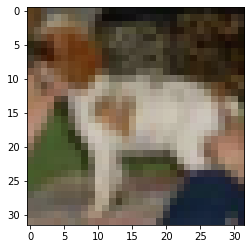

In [59]:
plt.imshow(test_img[12])

### PCA

In [17]:
# pca on flatten images
pca = PCA()
pca.fit(train_x) # SO SLOW

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [26]:
cumu_var = []
var_sum = 0
for i in range(pca.explained_variance_.shape[0]):
    var_sum += pca.explained_variance_[i]
    cumu_var.append(var_sum)

# get index of pcs so that all pcs before it explain 99% of variance
idx_var_99 = -1
for i in range(len(cumu_var)):
    if cumu_var[i]/cumu_var[-1] > 0.99:
        idx_var_99 = i
        break

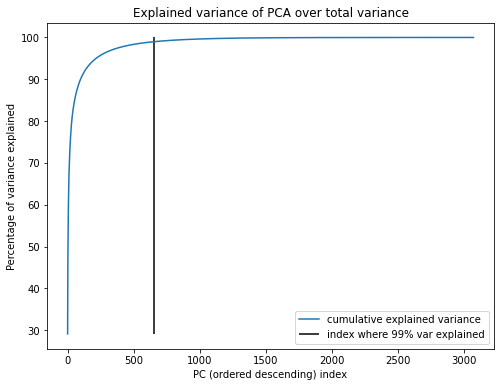

In [43]:
plt.figure(figsize=[8,6])
plt.plot(cumu_var/cumu_var[-1]*100.0, label="cumulative explained variance")
plt.vlines(idx_var_99, ymin=cumu_var[0]/cumu_var[-1]*100.0, ymax=1.0*100.0, label="index where 99% var explained")
plt.legend()
plt.title("Explained variance of PCA over total variance")
plt.xlabel("PC (ordered descending) index")
plt.ylabel("Percentage of variance explained")

plt.savefig('plot/cifar10_pca.png')

In [4]:
idx_var_99 = 657

In [5]:
# project
pca = PCA(n_components=idx_var_99)
train_pc = pca.fit_transform(train_x)
test_pc = pca.transform(test_x)

In [52]:
test_x.shape

(10000, 3072)

In [51]:
# save pca
import pickle
with open('model/cifar10_pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

### SVM, grid search

In [17]:
# get a random subset of training pc for grid search
idx = list(range(50000))
np.random.shuffle(idx)
idx = idx[:5000]
grid_x = train_pc[idx]
grid_label = train_label[idx]

In [20]:
clf_.decision_function

<bound method BaseSVC.decision_function of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)>

In [21]:
X = [[0, 0], [10, 10],[20,30],[30,30],[40, 30], [80,60], [80,50]]
y = [0, 1, 2, 3, 3, 4, 4]
clf = svm.SVC() 
clf.fit(X, y)

x_pred = [[10,10]]
p = np.array(clf.decision_function(x_pred)) # decision is a voting function
prob = np.exp(p)/np.sum(np.exp(p),axis=1, keepdims=True) # softmax after the voting
classes = clf.predict(x_pred)


In [27]:
# rbf kernel
Cs = [1,10,100,1000]
gammas = [1e-1,1e-2,1e-3,1e-4]
param_grid = {'gamma': gammas, 'C': Cs}

clf = svm.SVC()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(grid_x, grid_label)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.1, 0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

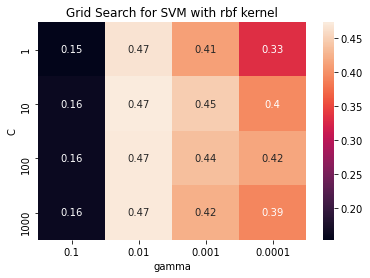

In [36]:
# plot grid search as headmap
results_df = pd.DataFrame(gs.cv_results_)
scores = np.array(results_df.mean_test_score).reshape(4, 4)
sns.heatmap(scores, annot=True, 
            xticklabels=param_grid['gamma'], yticklabels=param_grid['C'])
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Grid Search for SVM with rbf kernel")
plt.savefig('plot/svm_grid.png')

### Train SVM with best hyperparameters

In [38]:
%%time
clf = svm.SVC(C = 10, gamma = 0.01)
clf.fit(train_pc, train_label)

CPU times: user 1h 43min 31s, sys: 1min, total: 1h 44min 31s
Wall time: 1h 44min 32s


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
# save model
import pickle
with open('model/svm.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [50]:
y_pred = clf.predict(test_pc)
svm_accuracy = accuracy_score(test_label, y_pred)
svm_accuracy

0.5659